using device: cuda:0
The new sample is in cluster 3


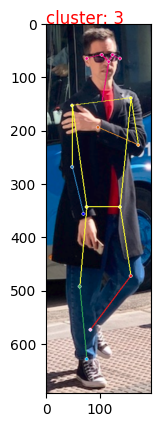

In [3]:
import os
import json

import joblib
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from model import HighResolutionNet
from draw_utils import draw_keypoints
import transforms

%matplotlib inline


def calculate_angle(p1, p2, p3):
    """Calculate the angle between the line p1-p2 and p2-p3."""
    vector_12 = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    vector_23 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
    norm_12 = np.linalg.norm(vector_12)
    norm_23 = np.linalg.norm(vector_23)

    if norm_12 == 0 or norm_23 == 0:
        return np.nan  # 返回NaN表示无法计算角度

    cosine_angle = np.dot(vector_12, vector_23) / (norm_12 * norm_23)
    # 防止浮点数计算误差导致的超出范围问题
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)


def extract_features(keypoints):
    features = []
    # 计算肩膀和臀部的中点
    left_shoulder = keypoints[5]
    right_shoulder = keypoints[6]
    left_hip = keypoints[11]
    right_hip = keypoints[12]
    midpoint_shoulder = [(left_shoulder[0] + right_shoulder[0]) / 2, (left_shoulder[1] + right_shoulder[1]) / 2]
    midpoint_hip = [(left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2]

    # 计算头部和肩膀、肩膀和臀部之间的角度
    torso_angle = calculate_angle(keypoints[0], midpoint_shoulder, midpoint_hip)
    shoulder_hip_angle = calculate_angle(midpoint_shoulder, midpoint_hip,
                                         [(left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2])

    # 添加相对高度特征
    height_features = keypoints[:, 1] - keypoints[0, 1]

    # 添加关键点之间的距离特征
    distance_features = []
    for i in range(len(keypoints)):
        for j in range(i + 1, len(keypoints)):
            distance_features.append(np.linalg.norm(keypoints[i] - keypoints[j]))

    features.extend([torso_angle, shoulder_hip_angle])
    features.extend(height_features)
    features.extend(distance_features)

    return features

def predict_all_person():
    # TODO
    pass


def predict_single_person(img_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"using device: {device}")

    flip_test = True
    resize_hw = (256, 192)
    # img_path = "./person.png"
    weights_path = "./pose_hrnet_w32_256x192.pth"
    keypoint_json_path = "person_keypoints.json"
    assert os.path.exists(img_path), f"file: {img_path} does not exist."
    assert os.path.exists(weights_path), f"file: {weights_path} does not exist."
    assert os.path.exists(keypoint_json_path), f"file: {keypoint_json_path} does not exist."

    data_transform = transforms.Compose([
        transforms.AffineTransform(scale=(1.25, 1.25), fixed_size=resize_hw),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # read json file
    with open(keypoint_json_path, "r") as f:
        person_info = json.load(f)

    # read single-person image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor, target = data_transform(img, {"box": [0, 0, img.shape[1] - 1, img.shape[0] - 1]})
    img_tensor = torch.unsqueeze(img_tensor, dim=0)

    # create model
    # HRNet-W32: base_channel=32
    # HRNet-W48: base_channel=48
    model = HighResolutionNet(base_channel=32)
    weights = torch.load(weights_path, map_location=device)
    weights = weights if "model" not in weights else weights["model"]
    model.load_state_dict(weights)
    model.to(device)
    model.eval()

    with torch.inference_mode():
        outputs = model(img_tensor.to(device))

        if flip_test:
            flip_tensor = transforms.flip_images(img_tensor)
            flip_outputs = torch.squeeze(
                transforms.flip_back(model(flip_tensor.to(device)), person_info["flip_pairs"]),
            )
            # feature is not aligned, shift flipped heatmap for higher accuracy
            # https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/issues/22
            flip_outputs[..., 1:] = flip_outputs.clone()[..., 0: -1]
            outputs = (outputs + flip_outputs) * 0.5

        keypoints, scores = transforms.get_final_preds(outputs, [target["reverse_trans"]], True)
        keypoints = np.squeeze(keypoints)
        scores = np.squeeze(scores)
        # 提取新样本的特征
        new_features = extract_features(keypoints)
        new_features = np.nan_to_num(new_features)
        new_features = scaler_loaded.transform([new_features])
        new_features_2d = pca_loaded.transform(new_features)

        # 预测新的样本属于哪个聚类
        new_label = kmeans_loaded.predict(new_features_2d)
        print(f"The new sample is in cluster {new_label[0]}")
        plt.text(0, 0, f"cluster: {new_label[0]}", fontsize=12, color='red')
        # print(f"keypoints: {keypoints},scores: {scores}")
        plot_img = draw_keypoints(img, keypoints, scores, thresh=0.2, r=3)
        plt.imshow(plot_img)
        plt.show()
        # plot_img.save("test_result.jpg")


if __name__ == '__main__':
    kmeans_loaded = joblib.load('./pkl/kmeans_model.pkl')
    scaler_loaded = joblib.load('./pkl/scaler.pkl')
    pca_loaded = joblib.load('./pkl/pca.pkl')

    data_root = r"C:\deep-learning-for-image-processing-master\pytorch_keypoint\HRNet\data\coco2017\val2017"
    count = 0
    # for img_name in os.listdir(data_root):
    #     random_choice = np.random.choice([0, 1], p=[0.1, 0.9])
    #     if random_choice == 0:
    #         count += 1
    #         img_path = os.path.join(data_root, img_name)
    #         predict_single_person(img_path)
    #     if count == 10:
    #         break

    imgpath = "./person.png"
    predict_single_person(imgpath)
